# Synthesis and integration of ideal IMU data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyins

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12

In this example we show how to generate IMU readings and check that they are appropriate.

We use a real-world trajectory computed with a postprocessing algorithm.

In [2]:
reference_trajectory = pd.read_csv("data/reference_trajectory.csv", index_col='time')

In [3]:
reference_trajectory.head()

,lat,lon,alt,VN,VE,VD,roll,pitch,heading
time,,,,,,,,,
0.000,58.005043,56.331263,150.499,-0.006,0.010,-0.006,2.30,1.15,85.33
0.005,58.005043,56.331263,150.499,-0.006,0.009,-0.005,2.30,1.15,85.33
0.010,58.005043,56.331263,150.499,-0.005,0.010,-0.005,2.31,1.15,85.33
0.015,58.005043,56.331263,150.499,-0.005,0.010,-0.005,2.31,1.15,85.33
0.020,58.005043,56.331263,150.499,-0.005,0.011,-0.005,2.31,1.15,85.33


## Using original trajectory

The recorded trajectory has one issue that velocity and attitude data are written with low number of digits.

If we try to generate IMU using it directly we will get very "noisy" and unrealistic IMU readings:

In [4]:
trajectory, imu = pyins.sim.generate_imu(reference_trajectory.index, 
                                         reference_trajectory[pyins.util.LLA_COLS], 
                                         reference_trajectory[pyins.util.RPH_COLS])

Text(0.5, 0, 'System time, s')

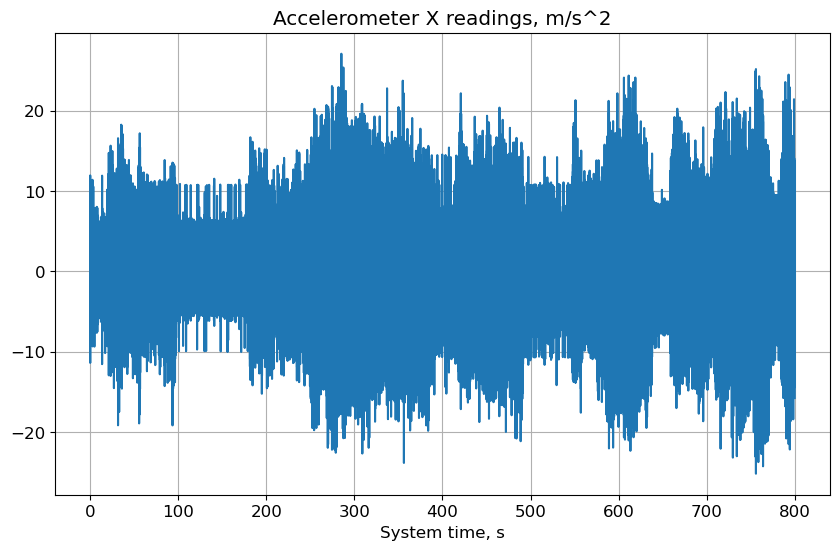

In [5]:
plt.plot(imu.accel_x)
plt.title("Accelerometer X readings, m/s^2")
plt.xlabel("System time, s")

It's not a good idea to use such IMU data because they are likely to cause quick error build up and will create unrealistic effects when scale factor errors or axes misalignment are modelled.

To alleviate this issue the trajectory must be smoothed.

## Using smoothed trajectory

pyins provides a convenient function to easily smooth any data with special handling of rotations.

Here we use smoothing time of 1 second:

In [6]:
smooth_trajectory = pyins.transform.smooth_state(reference_trajectory, 1.0)

Let's demonstrate how smoothing worked for the roll angle:

Text(0.5, 0, 'System time, s')

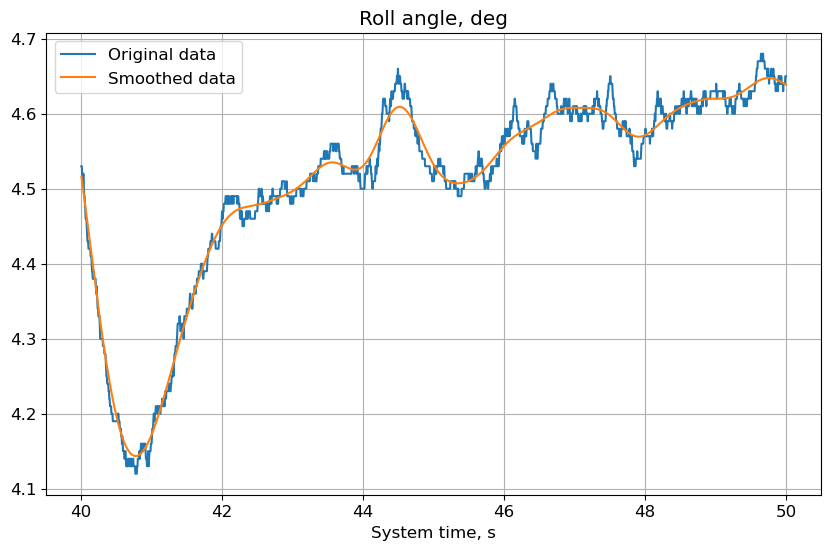

In [7]:
plt.title("Roll angle, deg")
plt.plot(reference_trajectory.roll.loc[40:50], label='Original data')
plt.plot(smooth_trajectory.roll.loc[40:50], label='Smoothed data')
plt.legend()
plt.xlabel("System time, s")

Generate IMU readings (rate values) using smoothed position and attitude data:

In [8]:
trajectory, imu = pyins.sim.generate_imu(smooth_trajectory.index, 
                                         smooth_trajectory[pyins.util.LLA_COLS], 
                                         smooth_trajectory[pyins.util.RPH_COLS])

We can see that accelerometer readings are now adeqaute:

Text(0.5, 0, 'System time, s')

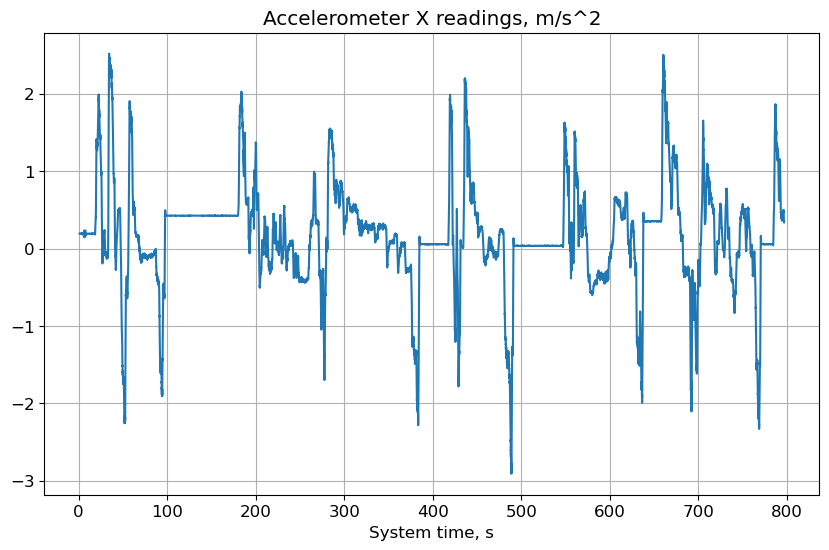

In [9]:
plt.plot(imu.accel_x)
plt.title("Accelerometer X readings, m/s^2")
plt.xlabel("System time, s")

## Integration of IMU data

Now compute increments and integrate them with strapdown algorithm:

In [10]:
increments = pyins.strapdown.compute_increments_from_imu(imu, 'rate')

integrator = pyins.strapdown.Integrator(trajectory.iloc[0])
trajectory_computed = integrator.integrate(increments)

We can compare computed and original trajectories:

In [11]:
error = pyins.transform.compute_state_difference(trajectory_computed, trajectory)

Plot position, velocity and attitude errors:

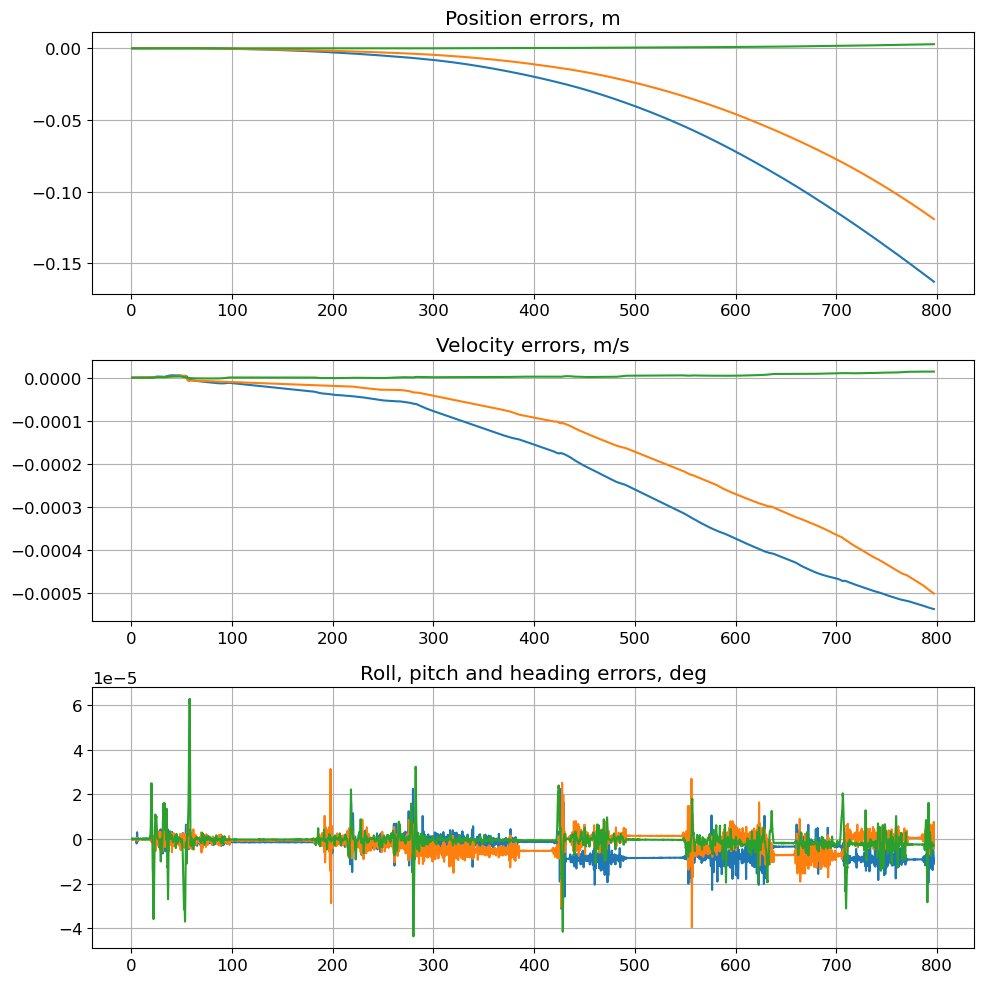

In [12]:
plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.title("Position errors, m")
plt.plot(error.north)
plt.plot(error.east)
plt.plot(error.down)

plt.subplot(312)
plt.title("Velocity errors, m/s")
plt.plot(error.VN)
plt.plot(error.VE)
plt.plot(error.VD)

plt.subplot(313)
plt.title("Roll, pitch and heading errors, deg")
plt.plot(error.roll)
plt.plot(error.pitch)
plt.plot(error.heading)

plt.tight_layout()

Such errors are essentially non-existent for pure inertial navigation and thus the generated IMU readings can be considered "ideal" for practical purposes. Also note that an integration algorithm will always accumulate some error anyway.

The process of synthesis and integration of IMU data is sometimes called "zero test", i. e. generated IMU data must give almost zero errors with respect to the original trajectory. In our example we can conclude that the "zero test" has passed.

To demonstrate this point let's add very low noise to gyro readings and compute trajectory. 

In [13]:
gyro_parameters = pyins.inertial_sensor.Parameters(noise=0.001 * pyins.transform.DRH_TO_RRS, rng=0)
imu_with_noise = pyins.inertial_sensor.apply_imu_parameters(imu, 'rate', gyro_parameters)

In [14]:
integrator = pyins.strapdown.Integrator(trajectory.iloc[0])
increments_with_noise = pyins.strapdown.compute_increments_from_imu(imu_with_noise, 'rate')
trajectory_computed_with_noise = integrator.integrate(increments_with_noise)

In [15]:
error_with_noise = pyins.transform.compute_state_difference(trajectory_computed_with_noise, trajectory)

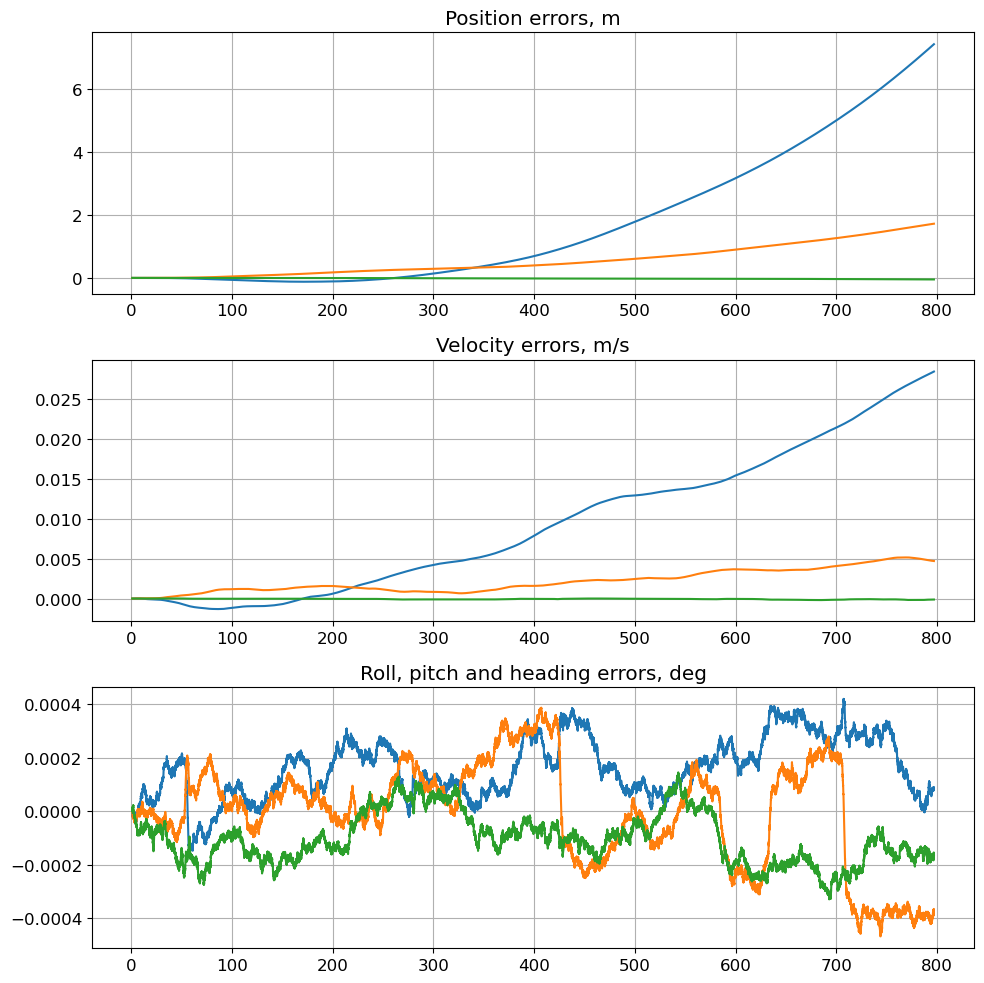

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(311)
plt.title("Position errors, m")
plt.plot(error_with_noise.north)
plt.plot(error_with_noise.east)
plt.plot(error_with_noise.down)

plt.subplot(312)
plt.title("Velocity errors, m/s")
plt.plot(error_with_noise.VN)
plt.plot(error_with_noise.VE)
plt.plot(error_with_noise.VD)

plt.subplot(313)
plt.title("Roll, pitch and heading errors, deg")
plt.plot(error_with_noise.roll)
plt.plot(error_with_noise.pitch)
plt.plot(error_with_noise.heading)

plt.tight_layout()

We can see that all errors were increased by about factor of 100. In reality there is also noise in accelerometers, biases and other IMU errors as well as errors in the initial conditions (mainly attitude "alignment" errors) and the errors will be much higher.